In [1]:
!pip install kaggle


In [2]:
import pandas as pd
import os
import shutil
import numpy as np
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm as tq
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import cv2
import albumentations as A
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Masukkan token baru Kaggle
token = input("Masukkan Kaggle API Token: ")

In [4]:
import json, os

# Buat folder ~/.kaggle
os.makedirs('/root/.kaggle', exist_ok=True)

# Buat file kaggle.json yang diperlukan Kaggle CLI
data = {
    "username": "dummyuser",
    "key": token          # isi token KGAT_xxxxx
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(data, f)

# Set permission sesuai requirement Kaggle
os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [5]:
!kaggle datasets list


ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           4036         76  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000           9847        244  1.0              
prince7489/employee-salary-dataset                              Employee Salary Dataset                                   1121  2025-11-16 14:32:04.360000           1173         30  0.9411765        


In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 97% 144M/149M [00:00<00:00, 524MB/s] 
100% 149M/149M [00:00<00:00, 518MB/s]


In [7]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [8]:
!mkdir original_data

In [9]:
# Path ke folder dataset asli
train_dir = 'Training'
val_dir = 'Testing'

# Folder hasil penggabungan
original_data_dir = 'original_data'
os.makedirs(original_data_dir, exist_ok=True)

# Fungsi untuk menggabungkan data dari folder sumber ke folder tujuan
def merge_data(source_dir, destination_dir):
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            destination_class_dir = os.path.join(destination_dir, class_name)
            os.makedirs(destination_class_dir, exist_ok=True)
            for filename in os.listdir(class_dir):
                src_file = os.path.join(class_dir, filename)

                # Hindari overwrite jika nama file sama
                dst_file = os.path.join(destination_class_dir, filename)
                if os.path.exists(dst_file):
                    name, ext = os.path.splitext(filename)
                    i = 1
                    while os.path.exists(os.path.join(destination_class_dir, f"{name}_{i}{ext}")):
                        i += 1
                    dst_file = os.path.join(destination_class_dir, f"{name}_{i}{ext}")

                shutil.copy(src_file, dst_file)

# Gabungkan data train dan test ke dalam original_data
merge_data(train_dir, original_data_dir)
merge_data(val_dir,original_data_dir)

print("Data telah digabungkan ke dalam folder 'original_data'.")


Data telah digabungkan ke dalam folder 'original_data'.


In [10]:
# Path ke direktori utama
base_dir = 'original_data'

# Mapping nama folder lama ke nama baru
rename_map = {
    'glioma': 'Glioma',
    'meningioma' : 'Meningioma',
    'notumor' : 'No_tumor',
    'pituitary' : 'Pituitary'
}

# Ganti nama folder
for old_name, new_name in rename_map.items():
    old_path = os.path.join(base_dir, old_name)
    new_path = os.path.join(base_dir, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Berhasil mengganti '{old_name}' menjadi '{new_name}'")
    else:
        print(f"Folder '{old_name}' tidak ditemukan")

print("Nama Penyakit dalam folder sudah diganti.")


Berhasil mengganti 'glioma' menjadi 'Glioma'
Berhasil mengganti 'meningioma' menjadi 'Meningioma'
Berhasil mengganti 'notumor' menjadi 'No_tumor'
Berhasil mengganti 'pituitary' menjadi 'Pituitary'
Nama Penyakit dalam folder sudah diganti.


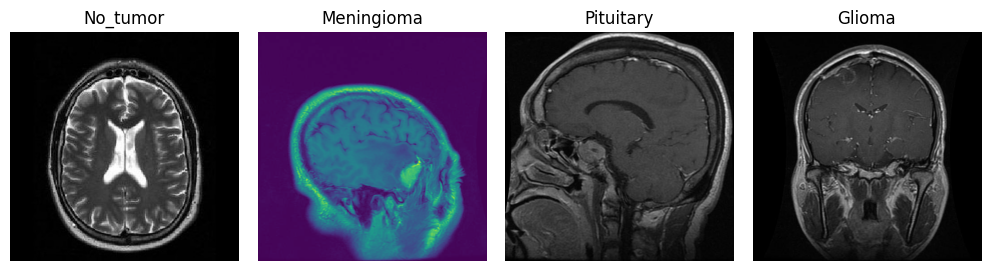

In [11]:
def visualize_images(base_dir):
    """Menampilkan satu gambar per label dari direktori tertentu."""

    plt.figure(figsize=(15, 15))

    for i, label in enumerate(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            image_files = [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]
            if image_files:
                random_image = random.choice(image_files)
                image_path = os.path.join(label_dir, random_image)
                image = plt.imread(image_path)

                plt.subplot(6, 6, i + 1)
                plt.imshow(image)
                plt.title(label)
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh visualisasi gambar dari folder training
visualize_images('original_data')

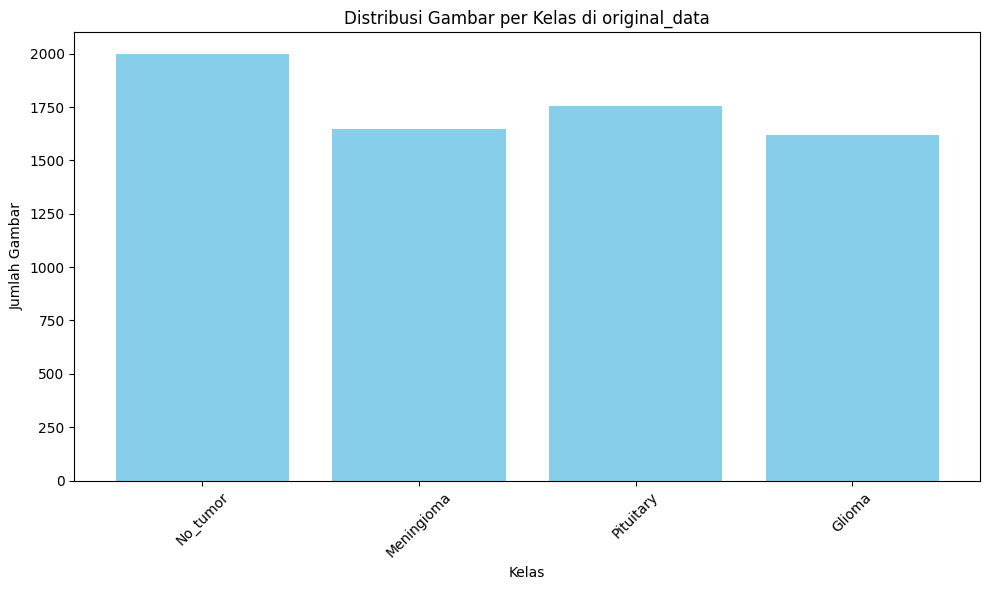

In [12]:
def plot_class_distribution(dataset_dir):
    """Menampilkan grafik distribusi jumlah gambar per kelas."""
    class_counts = {}

    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Distribusi Gambar per Kelas di original_data')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Tampilkan grafik
plot_class_distribution('original_data')

In [13]:
mypath = "original_data"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
Glioma,1621
Meningioma,1645
No_tumor,2000
Pituitary,1757


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       7023 non-null   object
 1   file_name  7023 non-null   object
 2   labels     7023 non-null   object
dtypes: object(3)
memory usage: 164.7+ KB


In [15]:
X= df['path']
y= df['labels']

#Split Data Training:Validation:Testing = 70:15:15

# Split 15% untuk test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Dari 85% data sisa, ambil 15/85 ≈ 0.176 untuk validation, sisanya jadi train
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)


In [16]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_tr, df_val, df_te]).reset_index(drop=True)

In [17]:
# Print hasil untuk melihat panjang size data training, validation, dan testing
print('Train size:', len(df_tr))
print('Validation size:', len(df_val))
print('Test size:', len(df_te))


Train size: 4918
Validation size: 1051
Test size: 1054


In [18]:
# Gabungkan semuanya menjadi satu DataFrame akhir
df_all = pd.concat([df_tr, df_val, df_te]).reset_index(drop=True)

In [19]:
# Gabungkan DataFrame df_tr, df_val, dan df_te
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))



set    labels    
test   Glioma         243
       Meningioma     247
       No_tumor       300
       Pituitary      264
train  Glioma        1135
       Meningioma    1152
       No_tumor      1401
       Pituitary     1230
val    Glioma         243
       Meningioma     246
       No_tumor       299
       Pituitary      263
dtype: int64 


                                         path      labels    set
2526      original_data/Glioma/Tr-gl_1012.jpg      Glioma  train
2966  original_data/Meningioma/Tr-me_1014.jpg  Meningioma  train
1914    original_data/No_tumor/Tr-no_0028.jpg    No_tumor  train
2060      original_data/Glioma/Te-gl_0021.jpg      Glioma  train
6305      original_data/Glioma/Tr-gl_0921.jpg      Glioma   test


In [20]:
datasource_path = "combine_data"
dataset_path = "Dataset-Final/"

In [21]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
      file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [22]:
# Buat file zip dari folder combine_data
shutil.make_archive('Dataset-Final', 'zip', 'Dataset-Final')

'/content/Dataset-Final.zip'